# Описание эксперимента 
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом
## Описание колонок
- value – значения метрики
- experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

## Задача
1. Сравните результат между тестом и контролем по двум кейсам:
 - Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
 - Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [163]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [184]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=";", decimal=",")
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [165]:
# считаем кол-во наблюдений в каждой группе
df.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,500


In [166]:
# считаем среднее значение в каждой группе
df.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


In [167]:
# считаем медиану в каждой группе
df.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


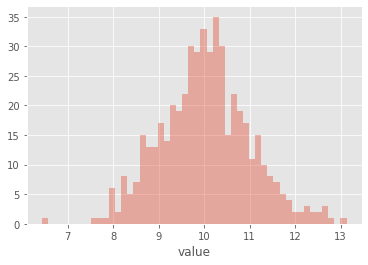

In [168]:
sns.distplot(df[df.experimentVariant == 'Control'].value, kde=False, bins=50)

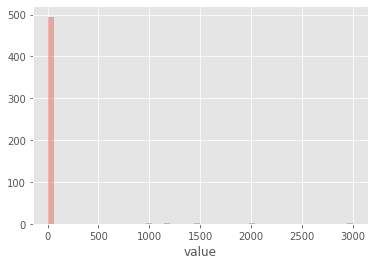

In [169]:
sns.distplot(df[df.experimentVariant == 'Treatment'].value, kde=False, bins=50)

In [170]:
# количество "выбросов":
df.query('value > 14').agg({'experimentVariant': 'count'})


experimentVariant    5
dtype: int64

In [171]:
x = df[df.experimentVariant == 'Control'].value

In [172]:
y = df[df.experimentVariant == 'Treatment'].value

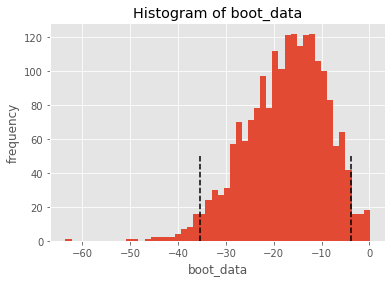

In [173]:
booted_data = get_bootstrap(x, y, boot_it = 2000)

In [174]:
booted_data["p_value"]

0.03689066278929322

In [175]:
booted_data["ci"]

,0
0.025,-35.409172
0.975,-3.867348


In [176]:
# доверительный интервал для разницы средних значений не включает 0 и p value < 0.05 => делаем вывод что средние значения 
# стат. значимо различаются

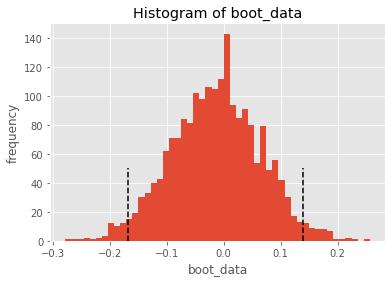

In [177]:
booted_data = get_bootstrap(x, y, statistic = np.median, boot_it = 2000)

In [178]:
booted_data["p_value"]

0.8639527376223523

In [179]:
booted_data["ci"]

,0
0.025,-0.168618
0.975,0.138738


In [180]:
# доверительный интервал для разницы медиан включает 0 и p value > 0.05 => делаем вывод что медианы стат. значимо не различаются

In [181]:
mannwhitneyu(x,y)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [ ]:
# p value > 0.05 => делаем вывод что средние значения рангов стат. значимо не различаются

## Выводы:
- Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
- Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
- Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
- U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы